# General setting

In all of the following graphs we use the transition probabilites estimated from group 4 of John Rust's 1987 paper. We stylize the cost parameters to (50, 400), instead if (10, 2.27). The simulation exercises are always with 200 buses over 70000 periods. For the construction of the uncertainty sets we always use the mean number of observations 4292 / 78.

In [1]:
extract_zips()

# Transition probabilities

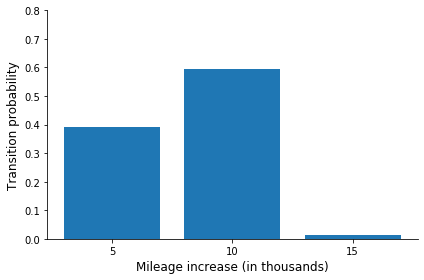

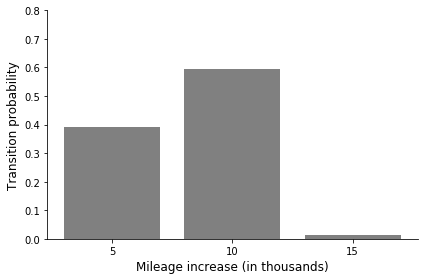

In [1]:
state = 30
get_probabilities(state)

upper bound [0.52720749 0.70719504 0.11116625]
lower bound [0.2715541  0.44410104 0.00127203]


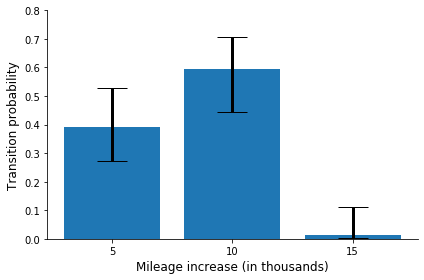

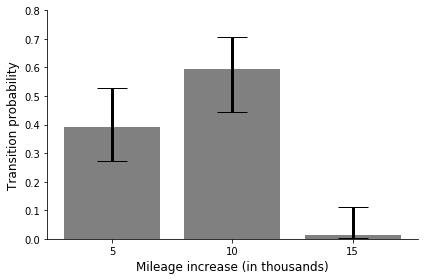

In [2]:
get_probabilities_bar(state)

In [4]:
df_probability_shift(20)

,0,4292_0.50_lin,4292_0.95_lin,4292_0.95_quad,4292_0.95_sqrt,2223_0.95_lin
0,0.391892,0.317649,0.24278,0.242926,0.242741,0.191725
1,0.595294,0.663264,0.72784,0.727537,0.727921,0.767527
2,0.012815,0.019086,0.02938,0.029537,0.029338,0.040749


In [5]:
df_probability_shift(30)

,0,4292_0.50_lin,4292_0.95_lin,4292_0.95_quad,4292_0.95_sqrt,2223_0.95_lin
0,0.391892,0.316675,0.240324,0.238958,0.241225,0.188232
1,0.595294,0.665463,0.733249,0.736639,0.731185,0.775076
2,0.012815,0.017863,0.026428,0.024404,0.027590,0.036691


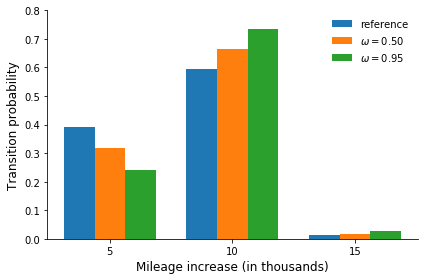

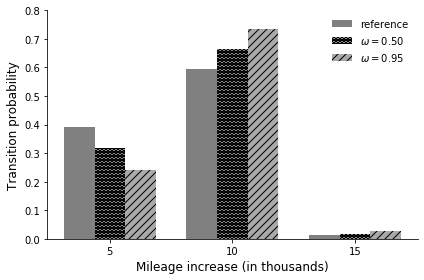

In [6]:
get_probability_shift(state)

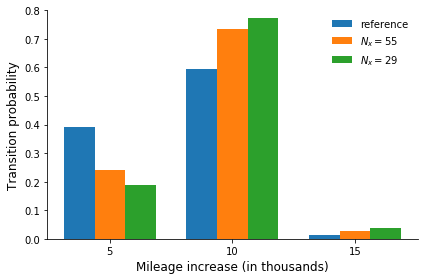

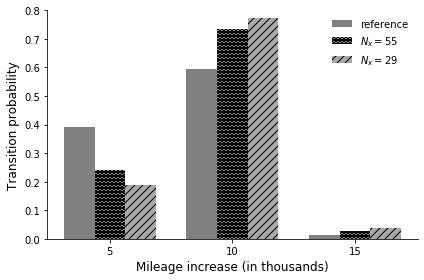

In [7]:
get_probability_shift_data(state)

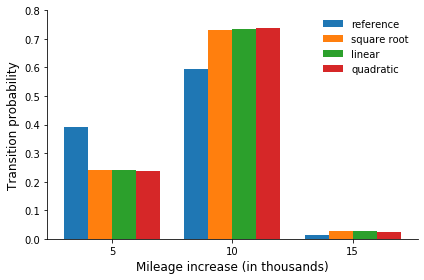

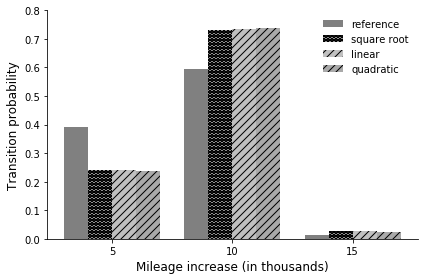

In [8]:
get_probability_shift_models(state, 0.95)

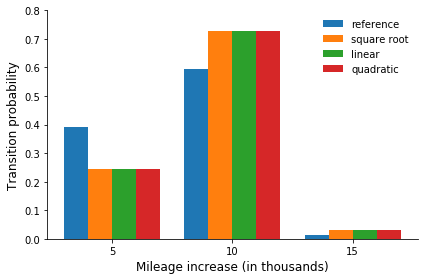

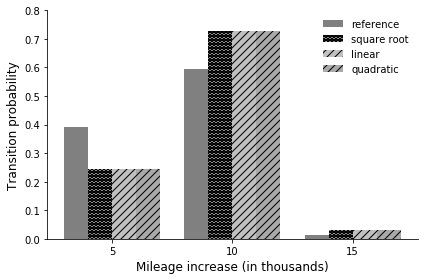

In [9]:
get_probability_shift_models(20, 0.95)

# Policy Features
 

In [36]:
min_states = {
    "linear": 0,
    "sqrt": 0,
    "quad": 0,
}
max_states = {
    "linear": 80,
    "sqrt": 80,
    "quad": 80,
}
state_steps = {
    "linear": 5,
    "sqrt": 5,
    "quad": 5,
}
df = df_maintenance_probabilties_lin(min_states["linear"], max_states["linear"])
df[df["mileage_thousands"] == 150]

,mileage_thousands,0_lin,0.5_lin,0.95_lin,0_sqrt,0.5_sqrt,0.95_sqrt,0_quad,0.5_quad,0.95_quad
30,150,0.696953,0.898875,0.983903,0.778648,0.924295,0.98609,0.591823,0.842803,0.969216


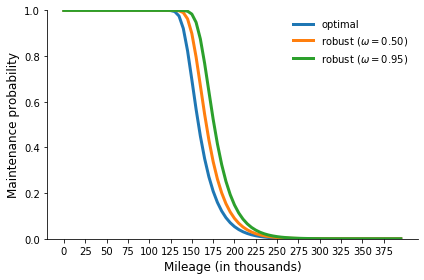

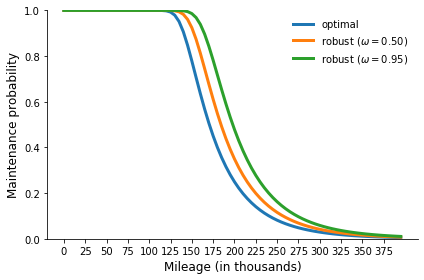

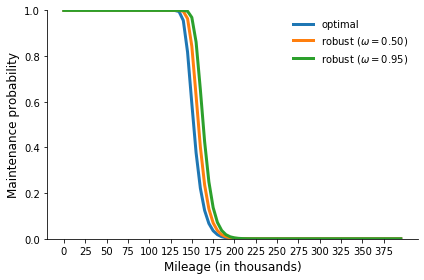

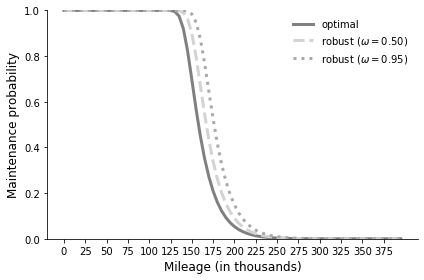

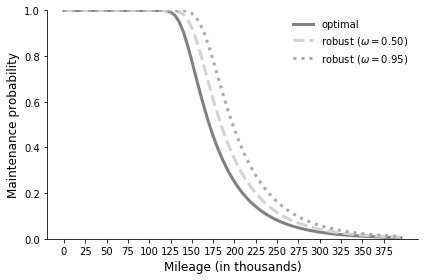

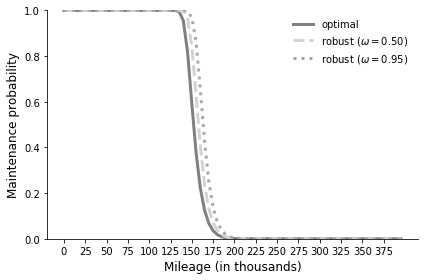

In [11]:
get_maintenance_probabilities(min_states, max_states, state_steps)

# Policy performance

In [38]:
max_period = 120

init_dict = {
    "disc_fac": 0.9999,
    "buses": 1,
    "periods": 200,
    "seed": 15,
}
df = get_demonstration_df(init_dict, max_period)

In [39]:
df

,months_ml,months_rob,opt_mileage,rob_mileage
0,0,0,0,0
1,1,1,5,5
2,2,2,10,10
3,3,3,10,10
4,4,4,10,10
...,...,...,...,...
115,113,113,55,15
116,114,114,60,20
117,115,115,60,20
118,116,116,60,20


In [42]:
df[df["months_ml"] == 45]

,months_ml,months_rob,opt_mileage,rob_mileage
45,45,45,140,140
46,45,46,0,145


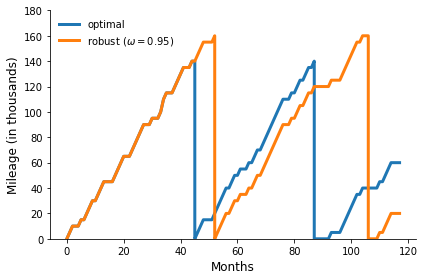

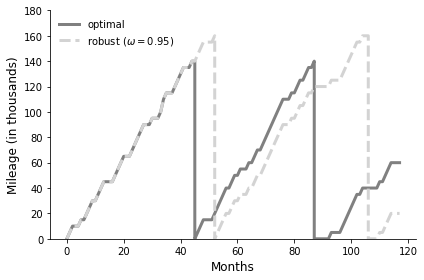

In [15]:
max_mileage = 180
get_demonstration(df, max_period, max_mileage)

In [16]:
df_thresholds("linear")

,omega,threshold
0,0.00,30
1,0.01,30
2,0.02,30
3,0.03,30
4,0.04,30
...,...,...
95,0.95,33
96,0.96,34
97,0.97,34
98,0.98,34


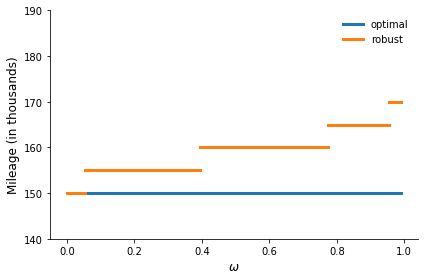

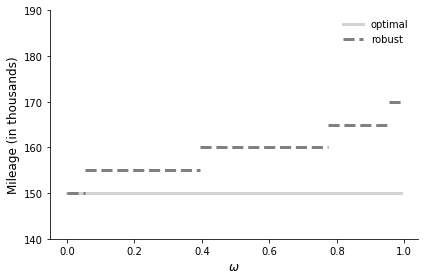

In [52]:
y_0 = 140
y_1 = 190
get_replacement_thresholds("linear", y_0, y_1)

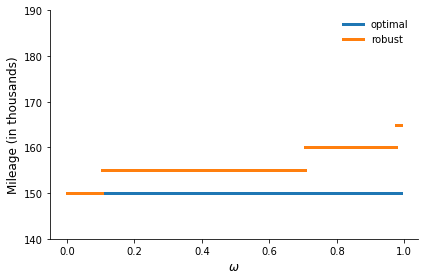

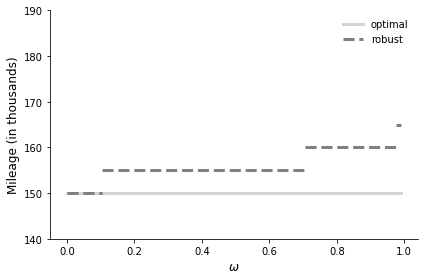

In [53]:
get_replacement_thresholds("quad", y_0, y_1)

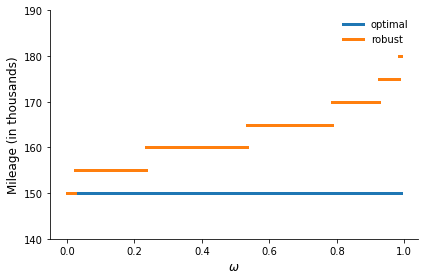

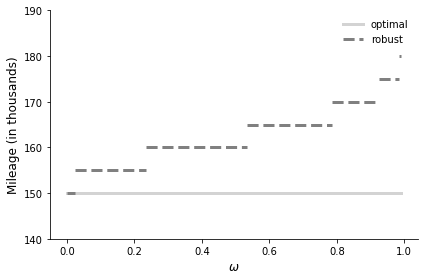

In [54]:
get_replacement_thresholds("sqrt", y_0, y_1)

In [62]:
df_lin = get_decision_rule_df("linear")
df_sqrt = get_decision_rule_df("sqrt")
df_quad = get_decision_rule_df("quad")

In [64]:
df_quad[df_quad["disc_strategy"] < df_quad["exp_value"]]

,months,disc_strategy,exp_value
19,19000,-80750.991226,-80500.34453
20,20000,-82105.749764,-80500.34453
21,21000,-83330.145069,-80500.34453
22,22000,-84438.548545,-80500.34453
23,23000,-85441.465302,-80500.34453
...,...,...,...
96,96000,-94973.586298,-80500.34453
97,97000,-94974.199069,-80500.34453
98,98000,-94974.753437,-80500.34453
99,99000,-94975.255498,-80500.34453


In [67]:
df_sqrt[df_sqrt["disc_strategy"] < df_sqrt["exp_value"]]

,months,disc_strategy,exp_value
25,25000,-82602.359368,-82512.340281
26,26000,-83306.190328,-82512.340281
27,27000,-83942.985859,-82512.340281
28,28000,-84518.897316,-82512.340281
29,29000,-85040.418900,-82512.340281
...,...,...,...
96,96000,-89990.550071,-82512.340281
97,97000,-89991.130409,-82512.340281
98,98000,-89991.655298,-82512.340281
99,99000,-89992.130404,-82512.340281


In [66]:
df_lin[df_lin["disc_strategy"] < df_lin["exp_value"]]

,months,disc_strategy,exp_value
22,22000,-82483.221375,-81794.349388
23,23000,-83463.319079,-81794.349388
24,24000,-84349.439902,-81794.349388
25,25000,-85152.312837,-81794.349388
26,26000,-85878.101074,-81794.349388
...,...,...,...
96,96000,-92771.001198,-81794.349388
97,97000,-92771.599266,-81794.349388
98,98000,-92772.140802,-81794.349388
99,99000,-92772.631032,-81794.349388


The underlying transition matrix is the worst case given omega=0.95
1.1342235155817022 1.0058734165356302 -81794.3493877381


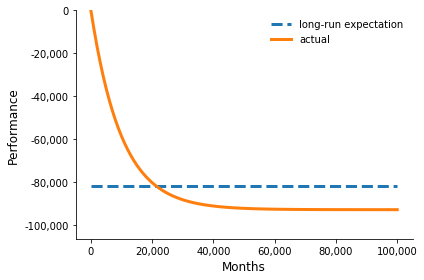

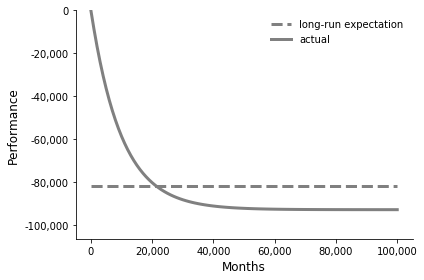

In [59]:
get_performance_decision_rules("linear")

The underlying transition matrix is the worst case given omega=0.95
1.090655775451889 1.005431843559294 -82512.34028112204


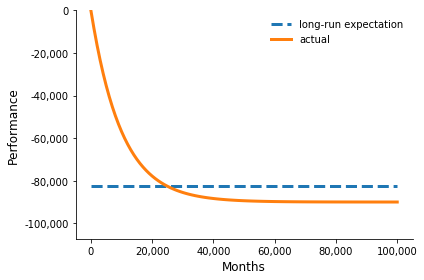

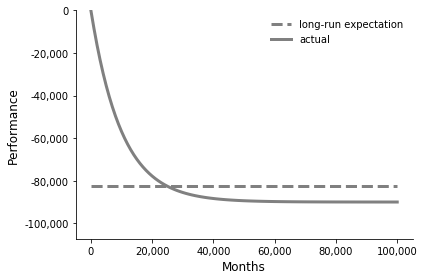

In [60]:
get_performance_decision_rules("sqrt")

The underlying transition matrix is the worst case given omega=0.95
1.179817427121251 1.004957599061134 -80500.34452976903


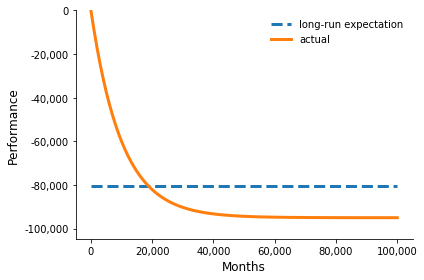

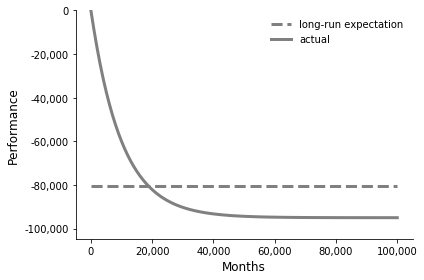

In [61]:
get_performance_decision_rules("quad")

In [4]:
df_lin = get_difference_df("linear")
df_sqrt = get_difference_df("quad")
df_quad = get_difference_df("sqrt")

The dataframe contains the difference for robust - nominal strategy.
The dataframe contains the difference for robust - nominal strategy.
The dataframe contains the difference for robust - nominal strategy.


In [5]:
df_lin

,omega,robust_95,robust_50,robust_05
0,0.00,-497.183650,-140.904337,-16.343253
1,0.01,-436.573249,-103.019650,-5.321194
2,0.02,-408.845094,-95.229216,2.781727
3,0.03,-388.855137,-82.968061,-3.884683
4,0.04,-370.867960,-72.651722,7.499251
...,...,...,...,...
95,0.95,550.061478,422.712116,152.508286
96,0.96,607.771893,441.180862,156.426774
97,0.97,644.501296,464.039215,167.875595
98,0.98,701.990106,498.494551,174.072816


In [6]:
df_quad

,omega,robust_95,robust_50,robust_05
0,0.00,-446.505044,-132.626448,-16.433210
1,0.01,-387.052589,-83.968170,-4.203880
2,0.02,-362.445453,-72.564630,5.738047
3,0.03,-340.306456,-68.518741,3.090745
4,0.04,-334.672661,-59.121874,3.518754
...,...,...,...,...
95,0.95,491.675339,385.690163,138.516678
96,0.96,552.931353,409.961533,155.408201
97,0.97,581.502459,434.805501,148.844765
98,0.98,627.681967,453.124494,154.304082


In [105]:
df_sqrt

,omega,robust_95,robust_50,robust_05
0,0.00,-431.080429,-108.658441,-3.467952
1,0.01,-389.469451,-90.288379,-7.770081
2,0.02,-386.589614,-88.675966,-5.178849
3,0.03,-349.055440,-77.645073,-0.442548
4,0.04,-334.713119,-56.993234,3.895580
...,...,...,...,...
95,0.95,474.014301,369.516565,126.987028
96,0.96,532.630253,392.496648,139.506000
97,0.97,568.125161,422.883367,146.891171
98,0.98,621.000198,440.842247,143.592680


In [106]:
df_quad

,omega,robust_95,robust_50,robust_05
0,0.00,-446.505044,-132.626448,-16.433210
1,0.01,-387.052589,-83.968170,-4.203880
2,0.02,-362.445453,-72.564630,5.738047
3,0.03,-340.306456,-68.518741,3.090745
4,0.04,-334.672661,-59.121874,3.518754
...,...,...,...,...
95,0.95,491.675339,385.690163,138.516678
96,0.96,552.931353,409.961533,155.408201
97,0.97,581.502459,434.805501,148.844765
98,0.98,627.681967,453.124494,154.304082


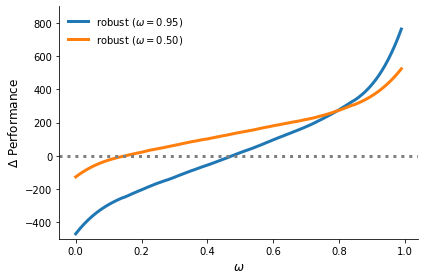

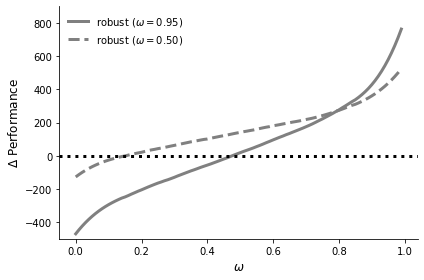

In [97]:
get_difference_plot("linear")

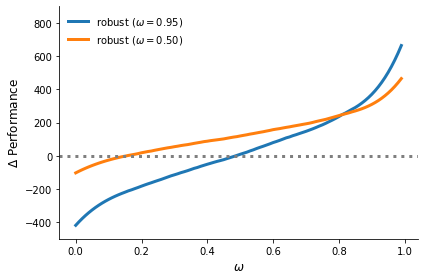

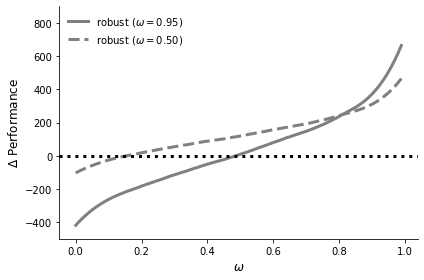

In [98]:
get_difference_plot("quad")

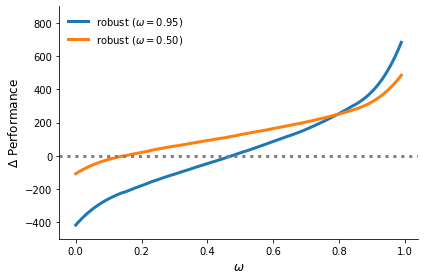

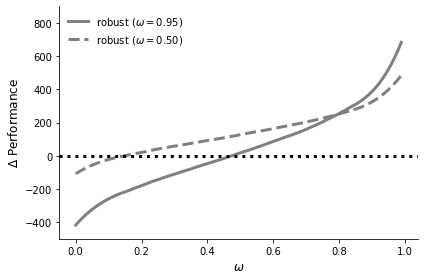

In [99]:
get_difference_plot("sqrt")

# Out of sample performance

0.0196
0.0146
0.0206


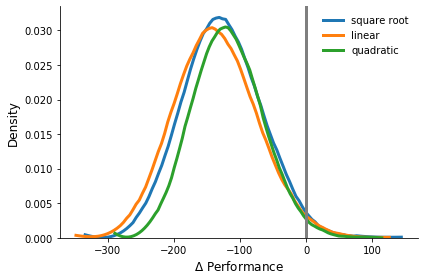

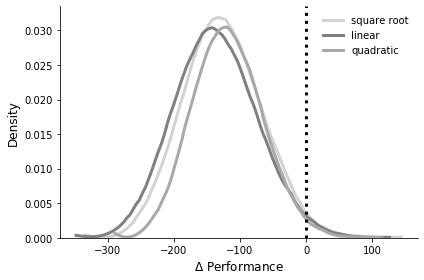

In [6]:
get_out_of_sample_diff(0.5, 100, 29)

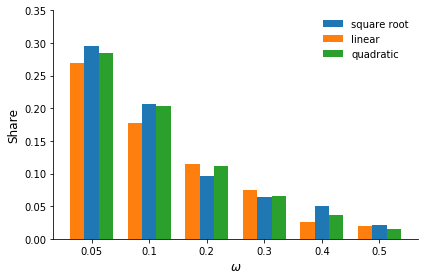

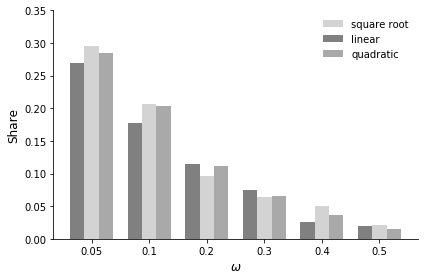

In [76]:
keys = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
width = 0.25
get_robust_performance(keys, width)